<table border="0">
 <tr>
    <td style="width:30%"><img src="img/potentials_logo.png" width="100%" align="justify"></td>
    <td style="width:70%"> <p style="width:100%;color:#B71C1C;font-size:24px;text-align:justify"> From electrons to phase diagrams </p> <p style="width:100%,font-size:16px">Day 03 Hands-on session (Part 3)</td>
 </tr>
</table>

In this notebook, we will use the EAM potential fitted in the previous day and move towards the AlLi phase diagram. We will use many of the methods and tools we discussed in the last sessions and put them together for calculation of phase diagrams. We start with the phase diagram of AlLi from Ref. [[1]](https://doi.org/10.1002/adma.19910031215). 

<img src="img/alli_phase_diagram.jpg" width="50%" align="justify">

In the last session, we calculated the melting temperatures of the pure phases Al and Li, thereby arriving at two points on the phase diagram. In this notebook, we will start with the left side of the phase diagram, until $X_{Li} < 0.5$.

As always, we start by importing the necessary modules.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pyiron_atomistics import Project
from helpers import *
from calphy.integrators import kb

We unpack the project; this can be deleted later when the calculations are run directly

In [4]:
pr = Project("phase_diagram_2")
pr.unpack("lial")

Most of the interesting features of the phase diagram at composition of $X_{Li} < 0.5$ lies between the temperature range of 700-1000 K. Therefore, we will calculate the free energy in this range. Similar to the previous session, we will use reversible scaling to obtain the free energy in this temperature range in a single calculation. We will recalculate the free energy of pure Al in FCC lattice and pure Al liquid first.

## Pure Al

### Solid

We start by creating an FCC structure. The converged lattice constant has been provided so as to speed up the calculations (CHANGE). 

In [6]:
structure = pr.create.structure.ase.bulk('Al', cubic=True).repeat(5)

We can visualise the structure.

In [7]:
structure.plot3d()

NGLWidget()

Our FCC lattice consists of a 5x5x5 supercell consisting of 500 atoms. Now we create a Calphy job in pyiron and assign a potential. The interatomic potentials have been prepared already. Let's take a look.

In [8]:
potential_list[0]

,Name,Filename,Model,Species,Config
0,Al_eam,[/mnt/c/Users/menon/Documents/winrepos/worksho...,EAM,[Al],"[pair_style eam/fs\n, pair_coeff * * AlLi.eam...."


The potential has been configured for pure Al.

In [9]:
xd2_sol = pr.create.job.Calphy("xp_sol")
xd2_sol.potential = potential_list[0]
xd2_sol.structure = structure

2022-05-30 10:13:26,923 - pyiron_log - WARNING - Job aborted - please remove it and run again! xp_sol


We have assigned the potential and structure. To speed up the calculations, we will run it on 2 cores.

In [10]:
xd2_sol.server.cores = 4

Now let's use the `calc_free_energy` method.

In [11]:
xd2_sol.calc_free_energy(temperature=[700, 1000], 
                     pressure=0, 
                     reference_phase="solid",
                     n_equilibration_steps=10000,
                     n_switching_steps=10000)

Before we actually run the calculation, let us discuss the various parameters. `temperature` keyword gives the temperature range over which the free energy is to be calculated. Since we provide `[700, 1000]`, the free energy is calculated between this range. `pressure` denotes the pressure of the calculation, we chose 0 in this case. Since we are using a solid FCC lattice, we set `reference_phase` to `"solid"`. This means that the Einstein crystal will be used as the reference system. Finally, we have `n_equilibration_steps` and `n_switching_steps`. `n_equilibration_steps` denotes the number of MD steps over which the system is equilibrated to the required temperature and pressure. `n_switching_steps` are the number of MD steps over which the system is continuously transformed between the given interatomic potential, and the reference Einstein crystal.

Finally we run the calculation.

In [12]:
xd2_sol.run()

### Liquid

Before we look at the output of the previous calculation, we will also calculate the free energy of the liquid phase. For this we can use the same structure as the solid. The Calphy workflow will first superheat the structure, melt it, and then equilibrate to the required temperature and pressure. Therefore the input for the pyiron job looks fairly same.

In [14]:
xd2_lqd = pr.create.job.Calphy("xp_lqd")
xd2_lqd.potential = potential_list[0]
xd2_lqd.structure = structure
xd2_lqd.server.cores = 4
xd2_lqd.calc_free_energy(temperature=[700, 1000], 
                     pressure=0, 
                     reference_phase="liquid",
                     n_equilibration_steps=10000,
                     n_switching_steps=10000)

The major change in the input is that the `reference_phase` is `"liquid"`, instead of `"solid"`. In this case, the Uhlenbeck-Ford model is used as the reference system instead of the Einstein crystal. Now run the job,

In [15]:
xd2_lqd.run()

/home/menon/miniconda3/envs/workshop/lib/python3.9/site-packages/h5io/_h5io.py:56: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Name', 'Filename', 'Model', 'Species', 'Config'], dtype='object')]

  data.to_hdf(fname, rootpath)


The job xp_lqd was saved and received the ID: 81


/home/menon/miniconda3/envs/workshop/lib/python3.9/site-packages/h5io/_h5io.py:56: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Name', 'Filename', 'Model', 'Species', 'Config'], dtype='object')]

  data.to_hdf(fname, rootpath)


Now we can look at the output; and plot the free energies of the two phases and calculate the melting temperature.

In [15]:
pr

{'groups': ['lial_thermodynamics_composition'], 'nodes': []}

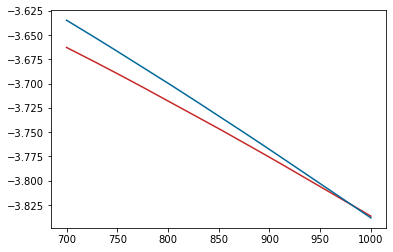

In [5]:
plt.plot(pr['lial_thermodynamics_composition/xp_sol'].output.temperature, pr['lial_thermodynamics_composition/xp_sol'].output.energy_free,
        label="Al solid", color='#C62828')
plt.plot(pr['lial_thermodynamics_composition/xp_lqd'].output.temperature, pr['lial_thermodynamics_composition/xp_lqd'].output.energy_free,
        label="Al liquid", color='#006899')

Great, finally, we will also calculate the free energy of the Al Li structure. Let's read in the structrue from the given file and plot it.

In [8]:
alli = pr.create.structure.ase.read('LiAl_poscar', format='vasp')

In [9]:
alli.plot3d()

NGLWidget()

We are calculating the free energy at zero percent Li, there will replace all the Li atoms with Al.

In [10]:
alli[:] = 'Al'

In [11]:
alli.plot3d()

NGLWidget()

Now we run the calculation to calculate the free energy at the same temperature range.

In [22]:
xd2_alli = pr.create.job.Calphy("xp_alli")
xd2_alli.potential = potential_list[0]
xd2_alli.structure = alli
xd2_alli.server.cores = 4
xd2_alli.calc_free_energy(temperature=[700, 1000], 
                     pressure=0, 
                     reference_phase="solid",
                     n_equilibration_steps=10000,
                     n_switching_steps=10000)
xd2_alli.run()

/home/menon/miniconda3/envs/workshop/lib/python3.9/site-packages/h5io/_h5io.py:56: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Name', 'Filename', 'Model', 'Species', 'Config'], dtype='object')]

  data.to_hdf(fname, rootpath)


The job xp_alli was saved and received the ID: 82


/home/menon/miniconda3/envs/workshop/lib/python3.9/site-packages/h5io/_h5io.py:56: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Name', 'Filename', 'Model', 'Species', 'Config'], dtype='object')]

  data.to_hdf(fname, rootpath)


## Free energy with composition

Now we will calculate the free energy of FCC solid, liquid and B32 phases with increasing Li compositions. We will use compositions from 0.1 to 0.5 Li. For the solid structure, we will first create an Al FCC structure, and replace randomly selected atoms with Li. Let's see how we do this.

In [12]:
structure = pr.create.structure.ase.bulk('Al', cubic=True).repeat(5)

In [13]:
structure.plot3d()

NGLWidget()

Now we assume we need to create 0.1 composition of Li. Therefore, the number of Li atoms needed are:

In [14]:
comp = 0.1
n_li = int(comp*len(structure))
n_li

50

Now we randomly replace 50 Al atoms with Li.

In [15]:
structure[np.random.permutation(len(structure))[:n_li]] = 'Li'

In [16]:
structure.plot3d()

NGLWidget()

We can see that some Al atoms are now replaced with Li. We also need to create B32 structures of varying compositions. For that we start with the LiAl B32 structure, and replace randomly selected Li atoms with Al, therby reducing the amount of Li in the structure.

In [17]:
structure = pr.create.structure.ase.read('LiAl_poscar', format='vasp')

In [18]:
structure.plot3d()

NGLWidget()

Once again, find the number of Li atoms that need to replaced.

In [19]:
n_li = int((0.5-comp)*len(structure))
n_li

172

Now replace random Li atoms with Al

In [20]:
rinds = np.random.choice(range(len(structure)//2), n_li, replace=False)
structure[rinds] = 'Al'

In [21]:
structure.plot3d()

NGLWidget()

Now we have all the necessary components in place. We can simply create a loop over the compositions and run the calculations.

In [ ]:
for count, comp in enumerate([0.1, 0.2, 0.3, 0.4, 0.5]):
    structure = pr.create.structure.ase.bulk('Al', cubic=True).repeat(5)
    n_li = int(comp*len(structure))
    structure[np.random.permutation(len(structure))[:n_li]] = 'Li'
    xd2_sol = pr.create.job.Calphy("x%d_sol"%count)
    xd2_sol.potential = potential_list[3]
    xd2_sol.structure = structure
    xd2_sol.server.cores = 4
    xd2_sol.calc_free_energy(temperature=[700, 1000], 
                         pressure=0, 
                         reference_phase="solid",
                         n_equilibration_steps=10000,
                         n_switching_steps=10000)
    xd2_sol.run()
    xd2_lqd = pr.create.job.Calphy("x%d_lqd"%count)
    xd2_lqd.potential = potential_list[3]
    xd2_lqd.structure = structure
    xd2_lqd.server.cores = 4
    xd2_lqd.calc_free_energy(temperature=[700, 1000], 
                         pressure=0, 
                         reference_phase="liquid",
                         n_equilibration_steps=10000,
                         n_switching_steps=10000)
    xd2_lqd.run()
    alli = pr.create.structure.ase.read('LiAl_poscar', format='vasp')
    n_li = int((0.5-comp)*len(structure))
    rinds = np.random.choice(range(len(alli)//2), n_li, replace=False)
    alli[rinds] = 'Al'
    xd2_alli = pr.create.job.Calphy("x%d_alli"%count)
    xd2_alli.potential = potential_list[3]
    xd2_alli.structure = alli
    xd2_alli.server.cores = 4
    xd2_alli.calc_free_energy(temperature=[700, 1000], 
                         pressure=0, 
                         reference_phase="solid",
                         n_equilibration_steps=10000,
                         n_switching_steps=10000)
    xd2_alli.run()

## Analysing the results

Now we can analyse the results of the above calculations. First we create an array of the composition values.

In [22]:
comp = np.arange(0, 0.6, 0.1)

For the initial set of analysis, we will choose a temperature of 700 K. 

In [91]:
temp = 700

The calculations we ran already has the free energy at all temperatures from 700-1000 K. We need to extract the free energy at the correct temperature. The `helpers.py` file in the folder contains some helper functions for this notebook. We provide a `fe_at` method which can extract the free energy at the required temperature. Let's take a look at the method.

In [92]:
fe_at?

Signature: fe_at(p, temp, threshold=0.1)
Docstring:
Get the free energy at a given temperature

Parameters
----------
p: pyiron Job
    Pyiron job with calculated free energy and temperature
    
temp: float
    Required temperature
    
threshold: optional, default 1E-1
    Minimum difference needed between required temperature and temperature found in pyiron job
    
Returns
-------
float: free energy value at required temperature
File:      /mnt/c/Users/menon/Documents/winrepos/workshop_preparation/phase_diagram/helpers.py
Type:      function


For for pure Al calculations, and for each composition, we extract the free energy at 700 K of the FCC, liquid and B32 phases.

In [93]:
fcc = []
b32 = []
lqd = []

fcc.append(fe_at(pr["lial_thermodynamics_composition/xp_sol"], temp))
lqd.append(fe_at(pr["lial_thermodynamics_composition/xp_lqd"], temp))
b32.append(fe_at(pr["lial_thermodynamics_composition/xp_alli"], temp))

for i in range(5):
    fcc.append(fe_at(pr["lial_thermodynamics_composition/x%d_sol"%i], temp))
    lqd.append(fe_at(pr["lial_thermodynamics_composition/x%d_lqd"%i], temp))
    b32.append(fe_at(pr["lial_thermodynamics_composition/x%d_alli"%i], temp))

Plot the results

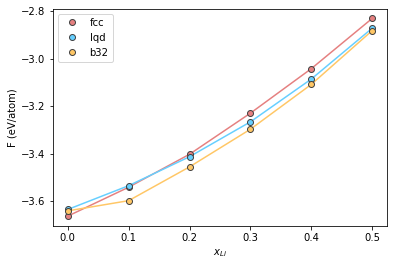

In [94]:
plt.plot(comp, fcc, '-', color="#e58080")
plt.plot(comp, lqd, '-', color="#66cfff")
plt.plot(comp, b32, '-', color="#ffc766")
plt.plot(comp, fcc, 'o', label='fcc', color="#e58080", markeredgecolor="#424242")
plt.plot(comp, lqd, 'o', label='lqd', color="#66cfff", markeredgecolor="#424242")
plt.plot(comp, b32, 'o', label='b32', color="#ffc766", markeredgecolor="#424242")
plt.xlabel(r"$x_{Li}$")
plt.ylabel(r"F (eV/atom)")
plt.legend()

### Configurational entropy

In the above example, we had off stoichiometric compositions, but we did not include configurational entropy for the solid structures. The easiest way to do this, which we will use here, is to employ the ideal mixing assumption. In the case of ideal mixing, the configuration entropy of mixing is given by,

$$
S_{mix} = -k_B (x \log(x) + (1-x) \log(1-x))
$$

We can add this directly to the free energy.

For the liquid phase, addition of configurational entropy explicitely is not needed as is it included in the free energy calculations.

In [30]:
smix = -kb*(comp*np.log(comp) + (1-comp)*np.log(1-comp))
smix[0] = 0

/tmp/ipykernel_81/1902816561.py:1: RuntimeWarning: divide by zero encountered in log
  smix = -kb*(comp*np.log(comp) + (1-comp)*np.log(1-comp))
/tmp/ipykernel_81/1902816561.py:1: RuntimeWarning: invalid value encountered in multiply
  smix = -kb*(comp*np.log(comp) + (1-comp)*np.log(1-comp))


In [97]:
fcc_mix = np.array(fcc)-temp*smix
b32_mix = np.array(b32)-temp*(smix-smix[-1])
lqd_mix = np.array(lqd)

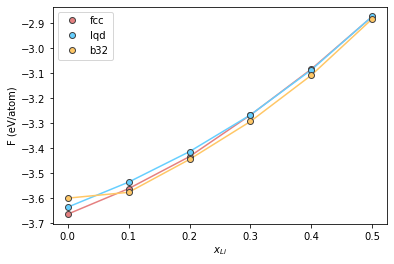

In [98]:
plt.plot(comp, fcc_mix, '-', color="#e58080")
plt.plot(comp, lqd_mix, '-', color="#66cfff")
plt.plot(comp, b32_mix, '-', color="#ffc766")
plt.plot(comp, fcc_mix, 'o', label='fcc', color="#e58080", markeredgecolor="#424242")
plt.plot(comp, lqd_mix, 'o', label='lqd', color="#66cfff", markeredgecolor="#424242")
plt.plot(comp, b32_mix, 'o', label='b32', color="#ffc766", markeredgecolor="#424242")
plt.xlabel(r"$x_{Li}$")
plt.ylabel(r"F (eV/atom)")
plt.legend()

To obtain the results in a computationally efficient way, we used composition along every 0.1 Li. We can fit a 3rd order polynomial to these points to get a finer grid. We will use `numpy.polyfit` for this purpose.

Let's first define a finer composition grid

In [99]:
comp_grid = np.linspace(0, 0.5, 1000)

Now we fit the free energy values and use this fit to revaluate the free energy on the finer grid.

In [100]:
fcc_fit = np.polyfit(comp, fcc_mix, 3)
fcc_fe = np.polyval(fcc_fit, comp_grid)

lqd_fit = np.polyfit(comp, lqd_mix, 3)
lqd_fe = np.polyval(lqd_fit, comp_grid)

b32_fit = np.polyfit(comp, b32_mix, 3)
b32_fe = np.polyval(b32_fit, comp_grid)

Plot the fits

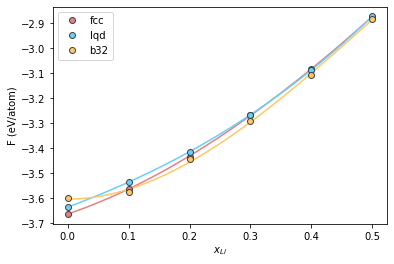

In [101]:
plt.plot(comp_grid, fcc_fe, '-', color="#e58080")
plt.plot(comp_grid, lqd_fe, '-', color="#66cfff")
plt.plot(comp_grid, b32_fe, '-', color="#ffc766")
plt.plot(comp, fcc_mix, 'o', label='fcc', color="#e58080", markeredgecolor="#424242")
plt.plot(comp, lqd_mix, 'o', label='lqd', color="#66cfff", markeredgecolor="#424242")
plt.plot(comp, b32_mix, 'o', label='b32', color="#ffc766", markeredgecolor="#424242")
plt.xlabel(r"$x_{Li}$")
plt.ylabel(r"F (eV/atom)")
plt.legend()

Now in order to identify regions we need to construct common tangents to free energy curves. To make this easier, we convert to free energy of mixing relative to the liquid. For this purpose, we subtract a straight line connecting the free energy of the pure Al liquid to the 0.5 Li liquid, from the calculated free energy. This same line will then be subtracted from the fcc and b32 curves. Our `helpers.py` module previously introduced includes helper methods to do this.

In [102]:
lqd_fe_norm, slope, intercept = normalise_fe(lqd_fe, comp_grid)
fcc_fe_norm = fcc_fe-(slope*comp_grid + intercept)
b32_fe_norm = b32_fe-(slope*comp_grid + intercept)

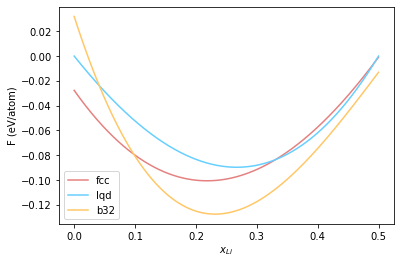

In [103]:
plt.plot(comp_grid, fcc_fe_norm, '-', color="#e58080", label='fcc')
plt.plot(comp_grid, lqd_fe_norm, '-', color="#66cfff", label='lqd')
plt.plot(comp_grid, b32_fe_norm, '-', color="#ffc766", label='b32')
plt.xlabel(r"$x_{Li}$")
plt.ylabel(r"F (eV/atom)")
plt.legend()

### Common tangent constructions

With the above curves, we can move on to common tangent constructions to identify regions where the two phases coexist. In order to calculate the common tangent for two curves $f$ and $g$, we can solve the following set of equationns:

$$
f^\prime (x_1) = g^\prime (x_1)
$$

$$
\frac{f(x_1) - g(x_2)}{(x_1 - x_2)} = f^\prime (x_1)
$$

$x_1$ and $x_2$ are the endpoints of the common tangent.

The fitting is done using the `fsolve` method from `scipy`. Once again, `helpers.py` module offers a function to do this fitting.

In [45]:
find_common_tangent?

Signature: find_common_tangent(fe1, fe2, guess_range)
Docstring:
Do a common tangent construction between two free energy curves.

Parameters
----------
fe1: numpy array
    first free energy curve

fe2: numpy array
    second free energy curve

guess_range: list of floats length 2
    The guess range to find end points of the common tangent

Returns
-------
res: list of floats length 2
    The end points of the common tangent
File:      /mnt/c/Users/menon/Documents/winrepos/workshop_preparation/phase_diagram/helpers.py
Type:      function


We will use this method to find the common tangent between the fcc and b32 curves

In [104]:
ct = find_common_tangent(fcc_fit, b32_fit, [0.0, 0.25])
ct

array([0.04690301, 0.13432104])

Note that we provided the polynomials that describe the free energy curves, obtained from fitting to the function. We have obtained $x_1$ and $x_2$. We can plot the common tangent now.

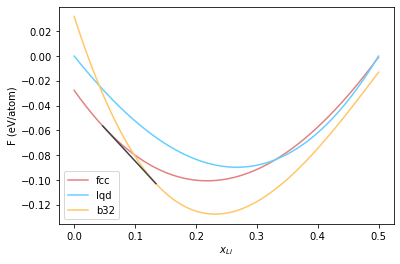

In [105]:
plt.plot(comp_grid, fcc_fe_norm, '-', color="#e58080", label='fcc')
plt.plot(comp_grid, lqd_fe_norm, '-', color="#66cfff", label='lqd')
plt.plot(comp_grid, b32_fe_norm, '-', color="#ffc766", label='b32')
plt.plot(ct, [np.polyval(fcc_fit, ct[0])-(slope*ct[0] + intercept),
             np.polyval(b32_fit, ct[1])-(slope*ct[1] + intercept)], color="#424242")
plt.xlabel(r"$x_{Li}$")
plt.ylabel(r"F (eV/atom)")
plt.legend()

Lets take a moment to analyse this plot. We obtained 0.047 and 0.134 as the end points of the common tangent. From the figure, this means that FCC is the most stable structure until $x_{Li} = 0.047$. Between $0.047 \leq x_{Li} \leq 0.134$, both fcc and b32 phases coexist. Finally, for $x_{Li} > 0.134$, b32 is the most stable phase. 

Therefore we have obtained already a slice of the phase diagram at 700 K. We can now put all of this methods together and easily calculate for different temperatures.

[0.05280969 0.1363657 ]


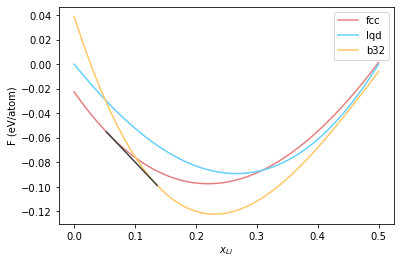

In [106]:
temp = 750

fcc = []
b32 = []
lqd = []
fcc.append(fe_at(pr["lial_thermodynamics_composition/xp_sol"], temp))
lqd.append(fe_at(pr["lial_thermodynamics_composition/xp_lqd"], temp))
b32.append(fe_at(pr["lial_thermodynamics_composition/xp_alli"], temp))
for i in range(5):
    fcc.append(fe_at(pr["lial_thermodynamics_composition/x%d_sol"%i], temp))
    lqd.append(fe_at(pr["lial_thermodynamics_composition/x%d_lqd"%i], temp))
    b32.append(fe_at(pr["lial_thermodynamics_composition/x%d_alli"%i], temp))
fcc_mix = np.array(fcc)-temp*smix
b32_mix = np.array(b32)-temp*(smix-smix[-1])
lqd_mix = np.array(lqd)
fcc_fit = np.polyfit(comp, fcc_mix, 3)
fcc_fe = np.polyval(fcc_fit, comp_grid)
lqd_fit = np.polyfit(comp, lqd_mix, 3)
lqd_fe = np.polyval(lqd_fit, comp_grid)
b32_fit = np.polyfit(comp, b32_mix, 3)
b32_fe = np.polyval(b32_fit, comp_grid)
lqd_fe_norm, slope, intercept = normalise_fe(lqd_fe, comp_grid)
fcc_fe_norm = fcc_fe-(slope*comp_grid + intercept)
b32_fe_norm = b32_fe-(slope*comp_grid + intercept)
ct = find_common_tangent(fcc_fit, b32_fit, [0.0, 0.25])
print(ct)
plt.plot(comp_grid, fcc_fe_norm, '-', color="#e58080", label='fcc')
plt.plot(comp_grid, lqd_fe_norm, '-', color="#66cfff", label='lqd')
plt.plot(comp_grid, b32_fe_norm, '-', color="#ffc766", label='b32')
plt.plot(ct, [np.polyval(fcc_fit, ct[0])-(slope*ct[0] + intercept),
             np.polyval(b32_fit, ct[1])-(slope*ct[1] + intercept)], color="#424242")
plt.xlabel(r"$x_{Li}$")
plt.ylabel(r"F (eV/atom)")
plt.legend()

[0.05998764 0.13910747]


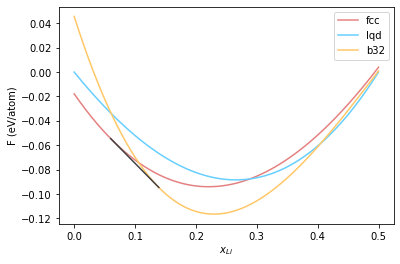

In [108]:
temp = 800

fcc = []
b32 = []
lqd = []
fcc.append(fe_at(pr["lial_thermodynamics_composition/xp_sol"], temp))
lqd.append(fe_at(pr["lial_thermodynamics_composition/xp_lqd"], temp))
b32.append(fe_at(pr["lial_thermodynamics_composition/xp_alli"], temp))
for i in range(5):
    fcc.append(fe_at(pr["lial_thermodynamics_composition/x%d_sol"%i], temp))
    lqd.append(fe_at(pr["lial_thermodynamics_composition/x%d_lqd"%i], temp))
    b32.append(fe_at(pr["lial_thermodynamics_composition/x%d_alli"%i], temp))
fcc_mix = np.array(fcc)-temp*smix
b32_mix = np.array(b32)-temp*(smix-smix[-1])
lqd_mix = np.array(lqd)
fcc_fit = np.polyfit(comp, fcc_mix, 3)
fcc_fe = np.polyval(fcc_fit, comp_grid)
lqd_fit = np.polyfit(comp, lqd_mix, 3)
lqd_fe = np.polyval(lqd_fit, comp_grid)
b32_fit = np.polyfit(comp, b32_mix, 3)
b32_fe = np.polyval(b32_fit, comp_grid)
lqd_fe_norm, slope, intercept = normalise_fe(lqd_fe, comp_grid)
fcc_fe_norm = fcc_fe-(slope*comp_grid + intercept)
b32_fe_norm = b32_fe-(slope*comp_grid + intercept)
ct = find_common_tangent(fcc_fit, b32_fit, [0.0, 0.25])
print(ct)
plt.plot(comp_grid, fcc_fe_norm, '-', color="#e58080", label='fcc')
plt.plot(comp_grid, lqd_fe_norm, '-', color="#66cfff", label='lqd')
plt.plot(comp_grid, b32_fe_norm, '-', color="#ffc766", label='b32')
plt.plot(ct, [np.polyval(fcc_fit, ct[0])-(slope*ct[0] + intercept),
             np.polyval(b32_fit, ct[1])-(slope*ct[1] + intercept)], color="#424242")
plt.xlabel(r"$x_{Li}$")
plt.ylabel(r"F (eV/atom)")
plt.legend()

Note that in this case we need a second common tangent construction to obtain coexistence between the b32 and liquid phases.

In [52]:
ct1 = find_common_tangent(b32_fit, lqd_fit, [0.3, 0.5])
print(ct1)

[0.3779039  0.42604146]


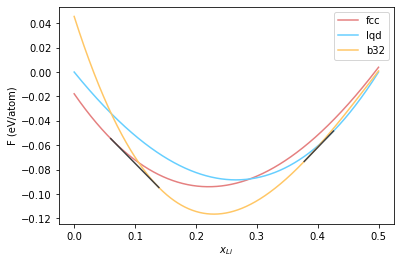

In [53]:
plt.plot(comp_grid, fcc_fe_norm, '-', color="#e58080", label='fcc')
plt.plot(comp_grid, lqd_fe_norm, '-', color="#66cfff", label='lqd')
plt.plot(comp_grid, b32_fe_norm, '-', color="#ffc766", label='b32')
plt.plot(ct, [np.polyval(fcc_fit, ct[0])-(slope*ct[0] + intercept),
             np.polyval(b32_fit, ct[1])-(slope*ct[1] + intercept)], color="#424242")
plt.plot(ct1, [np.polyval(b32_fit, ct1[0])-(slope*ct1[0] + intercept),
             np.polyval(lqd_fit, ct1[1])-(slope*ct1[1] + intercept)], color="#424242")
plt.xlabel(r"$x_{Li}$")
plt.ylabel(r"F (eV/atom)")
plt.legend()

[0.06612488 0.14114039]
[0.33507769 0.39736211]


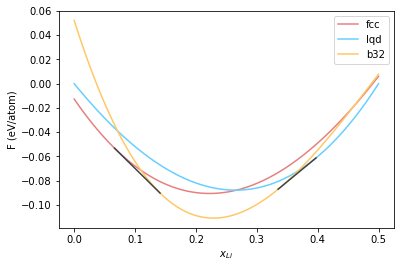

In [109]:
temp = 850

fcc = []
b32 = []
lqd = []
fcc.append(fe_at(pr["lial_thermodynamics_composition/xp_sol"], temp))
lqd.append(fe_at(pr["lial_thermodynamics_composition/xp_lqd"], temp))
b32.append(fe_at(pr["lial_thermodynamics_composition/xp_alli"], temp))
for i in range(5):
    fcc.append(fe_at(pr["lial_thermodynamics_composition/x%d_sol"%i], temp))
    lqd.append(fe_at(pr["lial_thermodynamics_composition/x%d_lqd"%i], temp))
    b32.append(fe_at(pr["lial_thermodynamics_composition/x%d_alli"%i], temp))
fcc_mix = np.array(fcc)-temp*smix
b32_mix = np.array(b32)-temp*(smix-smix[-1])
lqd_mix = np.array(lqd)
fcc_fit = np.polyfit(comp, fcc_mix, 3)
fcc_fe = np.polyval(fcc_fit, comp_grid)
lqd_fit = np.polyfit(comp, lqd_mix, 3)
lqd_fe = np.polyval(lqd_fit, comp_grid)
b32_fit = np.polyfit(comp, b32_mix, 3)
b32_fe = np.polyval(b32_fit, comp_grid)
lqd_fe_norm, slope, intercept = normalise_fe(lqd_fe, comp_grid)
fcc_fe_norm = fcc_fe-(slope*comp_grid + intercept)
b32_fe_norm = b32_fe-(slope*comp_grid + intercept)
ct = find_common_tangent(fcc_fit, b32_fit, [0.0, 0.25])
print(ct)
ct1 = find_common_tangent(b32_fit, lqd_fit, [0.3, 0.5])
print(ct1)
plt.plot(comp_grid, fcc_fe_norm, '-', color="#e58080", label='fcc')
plt.plot(comp_grid, lqd_fe_norm, '-', color="#66cfff", label='lqd')
plt.plot(comp_grid, b32_fe_norm, '-', color="#ffc766", label='b32')
plt.plot(ct, [np.polyval(fcc_fit, ct[0])-(slope*ct[0] + intercept),
             np.polyval(b32_fit, ct[1])-(slope*ct[1] + intercept)], color="#424242")
plt.plot(ct1, [np.polyval(b32_fit, ct1[0])-(slope*ct1[0] + intercept),
             np.polyval(lqd_fit, ct1[1])-(slope*ct1[1] + intercept)], color="#424242")

plt.xlabel(r"$x_{Li}$")
plt.ylabel(r"F (eV/atom)")
plt.legend()

Now we continue this process for temperatures of 900 and 1000 K.

[0.07370822 0.1439208 ]
[0.30479083 0.3709898 ]


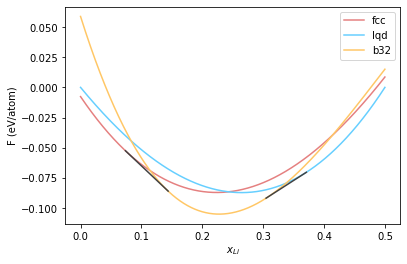

In [110]:
temp = 900

fcc = []
b32 = []
lqd = []
fcc.append(fe_at(pr["lial_thermodynamics_composition/xp_sol"], temp))
lqd.append(fe_at(pr["lial_thermodynamics_composition/xp_lqd"], temp))
b32.append(fe_at(pr["lial_thermodynamics_composition/xp_alli"], temp))
for i in range(5):
    fcc.append(fe_at(pr["lial_thermodynamics_composition/x%d_sol"%i], temp))
    lqd.append(fe_at(pr["lial_thermodynamics_composition/x%d_lqd"%i], temp))
    b32.append(fe_at(pr["lial_thermodynamics_composition/x%d_alli"%i], temp))
fcc_mix = np.array(fcc)-temp*smix
b32_mix = np.array(b32)-temp*(smix-smix[-1])
lqd_mix = np.array(lqd)
fcc_fit = np.polyfit(comp, fcc_mix, 3)
fcc_fe = np.polyval(fcc_fit, comp_grid)
lqd_fit = np.polyfit(comp, lqd_mix, 3)
lqd_fe = np.polyval(lqd_fit, comp_grid)
b32_fit = np.polyfit(comp, b32_mix, 3)
b32_fe = np.polyval(b32_fit, comp_grid)
lqd_fe_norm, slope, intercept = normalise_fe(lqd_fe, comp_grid)
fcc_fe_norm = fcc_fe-(slope*comp_grid + intercept)
b32_fe_norm = b32_fe-(slope*comp_grid + intercept)
ct = find_common_tangent(fcc_fit, b32_fit, [0.0, 0.25])
print(ct)
ct1 = find_common_tangent(b32_fit, lqd_fit, [0.3, 0.5])
print(ct1)
plt.plot(comp_grid, fcc_fe_norm, '-', color="#e58080", label='fcc')
plt.plot(comp_grid, lqd_fe_norm, '-', color="#66cfff", label='lqd')
plt.plot(comp_grid, b32_fe_norm, '-', color="#ffc766", label='b32')
plt.plot(ct, [np.polyval(fcc_fit, ct[0])-(slope*ct[0] + intercept),
             np.polyval(b32_fit, ct[1])-(slope*ct[1] + intercept)], color="#424242")
plt.plot(ct1, [np.polyval(b32_fit, ct1[0])-(slope*ct1[0] + intercept),
             np.polyval(lqd_fit, ct1[1])-(slope*ct1[1] + intercept)], color="#424242")

plt.xlabel(r"$x_{Li}$")
plt.ylabel(r"F (eV/atom)")
plt.legend()

[0.0812102  0.14675434]
[0.28059782 0.34547371]


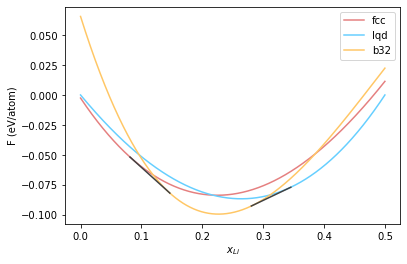

In [74]:
temp = 950

fcc = []
b32 = []
lqd = []
fcc.append(fe_at(pr["lial_thermodynamics_composition/xp_sol"], temp))
lqd.append(fe_at(pr["lial_thermodynamics_composition/xp_lqd"], temp))
b32.append(fe_at(pr["lial_thermodynamics_composition/xp_alli"], temp))
for i in range(5):
    fcc.append(fe_at(pr["lial_thermodynamics_composition/x%d_sol"%i], temp))
    lqd.append(fe_at(pr["lial_thermodynamics_composition/x%d_lqd"%i], temp))
    b32.append(fe_at(pr["lial_thermodynamics_composition/x%d_alli"%i], temp))
fcc_mix = np.array(fcc)-temp*smix
b32_mix = np.array(b32)-temp*(smix-smix[-1])
lqd_mix = np.array(lqd)
fcc_fit = np.polyfit(comp, fcc_mix, 3)
fcc_fe = np.polyval(fcc_fit, comp_grid)
lqd_fit = np.polyfit(comp, lqd_mix, 3)
lqd_fe = np.polyval(lqd_fit, comp_grid)
b32_fit = np.polyfit(comp, b32_mix, 3)
b32_fe = np.polyval(b32_fit, comp_grid)
lqd_fe_norm, slope, intercept = normalise_fe(lqd_fe, comp_grid)
fcc_fe_norm = fcc_fe-(slope*comp_grid + intercept)
b32_fe_norm = b32_fe-(slope*comp_grid + intercept)
ct = find_common_tangent(fcc_fit, b32_fit, [0.0, 0.25])
print(ct)
ct1 = find_common_tangent(b32_fit, lqd_fit, [0.3, 0.5])
print(ct1)
plt.plot(comp_grid, fcc_fe_norm, '-', color="#e58080", label='fcc')
plt.plot(comp_grid, lqd_fe_norm, '-', color="#66cfff", label='lqd')
plt.plot(comp_grid, b32_fe_norm, '-', color="#ffc766", label='b32')
plt.plot(ct, [np.polyval(fcc_fit, ct[0])-(slope*ct[0] + intercept),
             np.polyval(b32_fit, ct[1])-(slope*ct[1] + intercept)], color="#424242")
plt.plot(ct1, [np.polyval(b32_fit, ct1[0])-(slope*ct1[0] + intercept),
             np.polyval(lqd_fit, ct1[1])-(slope*ct1[1] + intercept)], color="#424242")

plt.xlabel(r"$x_{Li}$")
plt.ylabel(r"F (eV/atom)")
plt.legend()

[0.08497226 0.1481879 ]
[0.27012884 0.33272737]


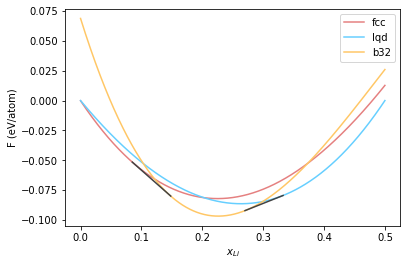

In [111]:
temp = 975

fcc = []
b32 = []
lqd = []
fcc.append(fe_at(pr["lial_thermodynamics_composition/xp_sol"], temp))
lqd.append(fe_at(pr["lial_thermodynamics_composition/xp_lqd"], temp))
b32.append(fe_at(pr["lial_thermodynamics_composition/xp_alli"], temp))
for i in range(5):
    fcc.append(fe_at(pr["lial_thermodynamics_composition/x%d_sol"%i], temp))
    lqd.append(fe_at(pr["lial_thermodynamics_composition/x%d_lqd"%i], temp))
    b32.append(fe_at(pr["lial_thermodynamics_composition/x%d_alli"%i], temp))
fcc_mix = np.array(fcc)-temp*smix
b32_mix = np.array(b32)-temp*(smix-smix[-1])
lqd_mix = np.array(lqd)
fcc_fit = np.polyfit(comp, fcc_mix, 3)
fcc_fe = np.polyval(fcc_fit, comp_grid)
lqd_fit = np.polyfit(comp, lqd_mix, 3)
lqd_fe = np.polyval(lqd_fit, comp_grid)
b32_fit = np.polyfit(comp, b32_mix, 3)
b32_fe = np.polyval(b32_fit, comp_grid)
lqd_fe_norm, slope, intercept = normalise_fe(lqd_fe, comp_grid)
fcc_fe_norm = fcc_fe-(slope*comp_grid + intercept)
b32_fe_norm = b32_fe-(slope*comp_grid + intercept)
ct = find_common_tangent(fcc_fit, b32_fit, [0.0, 0.25])
print(ct)
ct1 = find_common_tangent(b32_fit, lqd_fit, [0.3, 0.5])
print(ct1)
plt.plot(comp_grid, fcc_fe_norm, '-', color="#e58080", label='fcc')
plt.plot(comp_grid, lqd_fe_norm, '-', color="#66cfff", label='lqd')
plt.plot(comp_grid, b32_fe_norm, '-', color="#ffc766", label='b32')
plt.plot(ct, [np.polyval(fcc_fit, ct[0])-(slope*ct[0] + intercept),
             np.polyval(b32_fit, ct[1])-(slope*ct[1] + intercept)], color="#424242")
plt.plot(ct1, [np.polyval(b32_fit, ct1[0])-(slope*ct1[0] + intercept),
             np.polyval(lqd_fit, ct1[1])-(slope*ct1[1] + intercept)], color="#424242")

plt.xlabel(r"$x_{Li}$")
plt.ylabel(r"F (eV/atom)")
plt.legend()

[0.0890832  0.14978333]
[0.25995278 0.31921327]


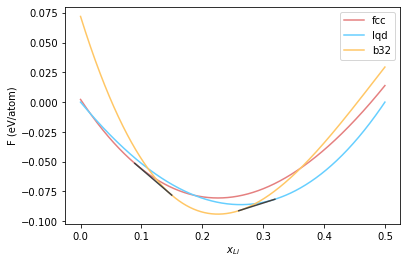

In [55]:
temp = 1000

fcc = []
b32 = []
lqd = []
fcc.append(fe_at(pr["lial_thermodynamics_composition/xp_sol"], temp))
lqd.append(fe_at(pr["lial_thermodynamics_composition/xp_lqd"], temp))
b32.append(fe_at(pr["lial_thermodynamics_composition/xp_alli"], temp))
for i in range(5):
    fcc.append(fe_at(pr["lial_thermodynamics_composition/x%d_sol"%i], temp))
    lqd.append(fe_at(pr["lial_thermodynamics_composition/x%d_lqd"%i], temp))
    b32.append(fe_at(pr["lial_thermodynamics_composition/x%d_alli"%i], temp))
fcc_mix = np.array(fcc)-temp*smix
b32_mix = np.array(b32)-temp*(smix-smix[-1])
lqd_mix = np.array(lqd)
fcc_fit = np.polyfit(comp, fcc_mix, 3)
fcc_fe = np.polyval(fcc_fit, comp_grid)
lqd_fit = np.polyfit(comp, lqd_mix, 3)
lqd_fe = np.polyval(lqd_fit, comp_grid)
b32_fit = np.polyfit(comp, b32_mix, 3)
b32_fe = np.polyval(b32_fit, comp_grid)
lqd_fe_norm, slope, intercept = normalise_fe(lqd_fe, comp_grid)
fcc_fe_norm = fcc_fe-(slope*comp_grid + intercept)
b32_fe_norm = b32_fe-(slope*comp_grid + intercept)
ct = find_common_tangent(fcc_fit, b32_fit, [0.0, 0.25])
print(ct)
ct1 = find_common_tangent(b32_fit, lqd_fit, [0.3, 0.5])
print(ct1)
plt.plot(comp_grid, fcc_fe_norm, '-', color="#e58080", label='fcc')
plt.plot(comp_grid, lqd_fe_norm, '-', color="#66cfff", label='lqd')
plt.plot(comp_grid, b32_fe_norm, '-', color="#ffc766", label='b32')
plt.plot(ct, [np.polyval(fcc_fit, ct[0])-(slope*ct[0] + intercept),
             np.polyval(b32_fit, ct[1])-(slope*ct[1] + intercept)], color="#424242")
plt.plot(ct1, [np.polyval(b32_fit, ct1[0])-(slope*ct1[0] + intercept),
             np.polyval(lqd_fit, ct1[1])-(slope*ct1[1] + intercept)], color="#424242")

plt.xlabel(r"$x_{Li}$")
plt.ylabel(r"F (eV/atom)")
plt.legend()

The free energy curves at 1000 K are interesting. We are above the melting temperature. Therefore, we would expect to see a region where liquid is the most stable structure. We see at the very left such a region exists. One more common tangent construction is needed to obtain this region.

In [58]:
ct0 = find_common_tangent(lqd_fit, fcc_fit, [0.01, 0.1])
print(ct0)

[-0.01145623  0.03518758]


Now let's put together all the common tangent constructions to arrive at the phase diagram.

In [114]:
fcc_temp = [700, 750, 800, 850, 900, 950, 975, ]
fcc_comp = [0.047, 0.052, 0.06, 0.066, 0.074, 0.081, 0.085]
fcc_lqd_temp = [975, ]
fcc_lqd_comp = [0.0]
fcc_b32_temp = [700, 750, 800, 850, 900, 950, 975]
fcc_b32_comp = [0.134, 0.136, 0.14, 0.141, 0.144, 0.147, 0.148]
b32_lqd_temp = [800, 850, 900, 950, 975, ]
b32_lqd_comp = [0.38, 0.335, 0.305, 0.28, 0.27, ]
lqd_temp = [800, 850, 900, 950, 975, ]
lqd_comp = [0.43, 0.397, 0.371, 0.34, 0.33, ]


In [ ]:
[0.08497226 0.1481879 ]
[0.27012884 0.33272737]

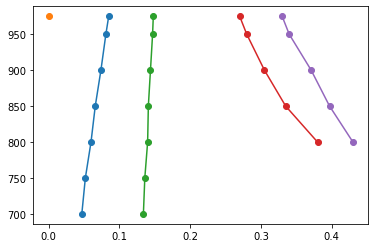

In [115]:
plt.plot(fcc_comp, fcc_temp, 'o-')
plt.plot(fcc_lqd_comp, fcc_lqd_temp, 'o-')

plt.plot(fcc_b32_comp, fcc_b32_temp, 'o-')
plt.plot(b32_lqd_comp, b32_lqd_temp, 'o-')
plt.plot(lqd_comp, lqd_temp, 'o-')